In [6]:
import sys
sys.path.insert(0, '..')
from eda_import import *
import pysam

In [1]:
%time adf = pd.read_csv('../__results/annotated-clv-sc-mapping-all-genes.csv')

CPU times: user 275 ms, sys: 46.1 ms, total: 321 ms
Wall time: 383 ms


In [2]:
adf.head()

,gene_name,gene_id,transcript_id,seqname,source,sc,clv,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,mclv
0,TSPAN6,ENSG00000000003,ENST00000373020,X,protein_coding,99885795,99883667,-,ensembl_havana,ensembl_havana,False,False,99885794,1,99883667
1,TNMD,ENSG00000000005,ENST00000373031,X,protein_coding,99854714,99854882,+,ensembl_havana,ensembl_havana,False,False,99854715,1,99854882
2,DPM1,ENSG00000000419,ENST00000371582,20,protein_coding,49551669,49551404,-,ensembl_havana,havana,False,False,49551668,2,49551404
3,DPM1,ENSG00000000419,ENST00000371583,20,protein_coding,49551669,49551490,-,ensembl_havana,ensembl,False,False,49551668,1,49551485
4,DPM1,ENSG00000000419,ENST00000371584,20,protein_coding,49551669,49551481,-,ensembl_havana,havana,False,True,49551668,1,49551485


In [3]:
adf.shape

(82182, 15)

In [4]:
adf.gene_id.unique().shape

(22563,)

# Search for hexamers for annotated cleavage sites

In [7]:
from hexamer_search import search_hexamer

def search_hexamer_wrapper(refseq, chrm, clv, strand, window=50):
    chrm = chrm.replace('chr', '')
    res = search_hexamer.search(refseq, chrm, clv, strand, window)
    if res is None:
        res = ['NA', -1, -1]
    return pd.Series(res, index=['hexamer', 'hexamer_id', 'hexamer_loc0'])

In [9]:
CHRS = [str(_) for _ in range(1, 23)] + ['X', 'Y', 'MT']

In [10]:
_cols = ['seqname', 'gene_name', 'gene_id', 'strand', 'mclv']
bdf = adf[_cols].drop_duplicates().query("seqname in {0}".format(CHRS))

In [11]:
bdf.shape

(52561, 5)

In [12]:
# as pysam is 0-based
bdf['mclv0'] = bdf['mclv'] - 1

In [15]:
bdf.head(3)

,seqname,gene_name,gene_id,strand,mclv,mclv0
0,X,TSPAN6,ENSG00000000003,-,99883667,99883666
1,X,TNMD,ENSG00000000005,+,99854882,99854881
2,20,DPM1,ENSG00000000419,-,49551404,49551403


In [16]:
REF_FA = '../reference_data/Homo_sapiens.GRCh37.75.dna_sm.primary_assembly.fa'
refseq = pysam.FastaFile(REF_FA)

In [17]:
%%time
hexm_df = bdf.apply(
    lambda row: search_hexamer_wrapper(refseq, row.seqname, row.mclv0, row.strand), 
    axis=1)

CPU times: user 21.3 s, sys: 1.06 s, total: 22.3 s
Wall time: 22.3 s


In [18]:
cdf = pd.concat([bdf, hexm_df], axis=1)

In [19]:
cdf.head(2)

,seqname,gene_name,gene_id,strand,mclv,mclv0,hexamer,hexamer_id,hexamer_loc0
0,X,TSPAN6,ENSG00000000003,-,99883667,99883666,TATAAA,4,99883697
1,X,TNMD,ENSG00000000005,+,99854882,99854881,AATAAA,1,99854858


In [21]:
cdf['hexamer_loc'] = cdf['hexamer_loc0'].apply(lambda v: v + 1 if v != -1 else v)

In [22]:
cdf.query('gene_id == "ENSG00000000419"')

,seqname,gene_name,gene_id,strand,mclv,mclv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc
2,20,DPM1,ENSG00000000419,-,49551404,49551403,AATAAA,1,49551433,49551434
3,20,DPM1,ENSG00000000419,-,49551485,49551484,ATTAAA,2,49551512,49551513


In [23]:
def calc_aclv2ahex_dist(row):
    """calculate distance between annotated clv to annotated hexamer"""
    clv, hex_loc = row.mclv, row.hexamer_loc
    if hex_loc != -1:
        return clv - hex_loc
    else:
        return np.nan

In [24]:
cdf['sdist_aclv2ahex'] = cdf.apply(calc_aclv2ahex_dist, axis=1)

In [25]:
cdf.head(2)

,seqname,gene_name,gene_id,strand,mclv,mclv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,sdist_aclv2ahex
0,X,TSPAN6,ENSG00000000003,-,99883667,99883666,TATAAA,4,99883697,99883698,-31.0
1,X,TNMD,ENSG00000000005,+,99854882,99854881,AATAAA,1,99854858,99854859,23.0


In [29]:
_cols = ['seqname', 'gene_name', 'gene_id', 'mclv', 'hexamer', 'sdist_aclv2ahex']
ddf = cdf[_cols].drop_duplicates().sort_values('gene_id')

In [30]:
assert ddf.shape[0] == 52561

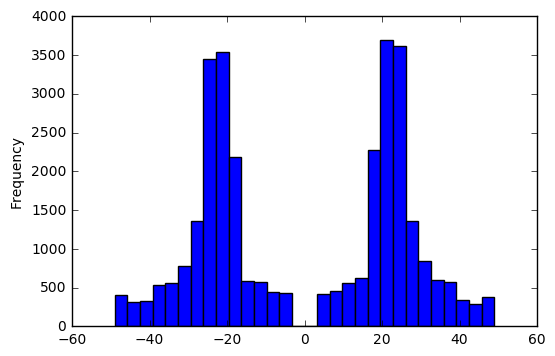

In [31]:
ddf.sdist_aclv2ahex.plot.hist(bins=30)

In [32]:
ddf.hexamer.value_counts()

NA        21014
AATAAA    17402
ATTAAA    4600 
TATAAA    1144 
AGTAAA    1128 
AAGAAA    901  
AAAAAG    862  
TTTAAA    841  
CATAAA    686  
AATACA    646  
AATATA    584  
GATAAA    581  
AATGAA    572  
AAAACA    466  
GGGGCT    457  
ACTAAA    358  
AATAGA    319  
Name: hexamer, dtype: int64

In [33]:
ddf.head(2)

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
0,X,TSPAN6,ENSG00000000003,99883667,TATAAA,-31.0
1,X,TNMD,ENSG00000000005,99854882,AATAAA,23.0


## To see if it's possible that one mclv is used in multiple gene.

In [34]:
%time gene_count_per_mclv = ddf.groupby(['seqname', 'mclv']).apply(lambda g: g.gene_id.unique().shape[0])

CPU times: user 6.22 s, sys: 40.7 ms, total: 6.26 s
Wall time: 6.21 s


In [35]:
gene_count_per_mclv.describe()

count    52429.000000
mean     1.002518    
std      0.107659    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      19.000000   
dtype: float64

In [36]:
gene_count_per_mclv[gene_count_per_mclv > 1].shape[0] / gene_count_per_mclv.shape[0]

0.001888267943313815

In [37]:
gene_count_per_mclv[gene_count_per_mclv > 1].value_counts()

2     95
19    1 
14    1 
5     1 
3     1 
dtype: int64

So it's possible, but indeed very rare (0.19%) of the CSs, and most of them shared by 2 genes. Also, those genes that share mclv seem to be probably closely related based on their names.

Check a few concrete ones:

In [38]:
gene_count_per_mclv[gene_count_per_mclv > 1].sample(5)

seqname  mclv    
14       39820397    2
11       66412103    2
17       15640874    2
15       90815440    2
8        10582909    2
dtype: int64

In [39]:
ddf.query('mclv == 234681945')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
75228,2,UGT1A5,ENSG00000240224,234681945,AATAAA,19.0
75510,2,UGT1A1,ENSG00000242366,234681945,AATAAA,19.0
75601,2,UGT1A3,ENSG00000243135,234681945,AATAAA,19.0
75795,2,UGT1A7,ENSG00000244122,234681945,AATAAA,19.0
75833,2,UGT1A4,ENSG00000244474,234681945,AATAAA,19.0


In [40]:
ddf.query('mclv == 66412103')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
56706,11,RBM4,ENSG00000173933,66412103,GATAAA,40.0
75951,11,RBM14-RBM4,ENSG00000248643,66412103,GATAAA,40.0


In [41]:
ddf.query('mclv == 148564074')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
1290,X,IDS,ENSG00000010404,148564074,ATTAAA,-18.0
75372,X,IDS,ENSG00000241489,148564074,ATTAAA,-18.0


In [42]:
ddf.query('mclv == 10512210')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
57489,1,APITD1,ENSG00000175279,10512210,NA,NaN
76168,1,APITD1-CORT,ENSG00000251503,10512210,NA,NaN


In [43]:
ddf.query('mclv == 50723247')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
75638,10,PGBD3,ENSG00000243251,50723247,AATAAA,-20.0
76973,10,ERCC6-PGBD3,ENSG00000258838,50723247,AATAAA,-20.0


In [44]:
gene_count_per_mclv[gene_count_per_mclv == 19]

seqname  mclv     
5        140892546    19
dtype: int64

In [45]:
ddf.query('mclv == 140892546')

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
7667,5,PCDHGA2,ENSG00000081853,140892546,AATAAA,25.0
70034,5,PCDHGA1,ENSG00000204956,140892546,AATAAA,25.0
75287,5,PCDHGC5,ENSG00000240764,140892546,AATAAA,25.0
75530,5,PCDHGC4,ENSG00000242419,140892546,AATAAA,25.0
76185,5,PCDHGA12,ENSG00000253159,140892546,AATAAA,25.0
76195,5,PCDHGB6,ENSG00000253305,140892546,AATAAA,25.0
76213,5,PCDHGA5,ENSG00000253485,140892546,AATAAA,25.0
76215,5,PCDHGA7,ENSG00000253537,140892546,AATAAA,25.0
76226,5,PCDHGA6,ENSG00000253731,140892546,AATAAA,25.0
76227,5,PCDHGA8,ENSG00000253767,140892546,AATAAA,25.0


## Distribution of distances between neighboring CSs of the same gene in the annotation

In [46]:
ddf.head()

,seqname,gene_name,gene_id,mclv,hexamer,sdist_aclv2ahex
0,X,TSPAN6,ENSG00000000003,99883667,TATAAA,-31.0
1,X,TNMD,ENSG00000000005,99854882,AATAAA,23.0
2,20,DPM1,ENSG00000000419,49551404,AATAAA,-30.0
3,20,DPM1,ENSG00000000419,49551485,ATTAAA,-28.0
6,1,SCYL3,ENSG00000000457,169822215,AATAAA,-36.0


In [47]:
%%time
neighbor_dist = ddf.groupby(['gene_name', 'gene_id']).apply(
    lambda g: np.diff(np.sort(g.mclv.unique())))

CPU times: user 2.75 s, sys: 13.1 ms, total: 2.77 s
Wall time: 2.76 s


In [48]:
ndser = pd.Series(np.concatenate(neighbor_dist.values))

See the distribution

In [49]:
ndser.describe(percentiles=np.arange(0, 1.01, 0.1)).astype(int).to_frame(name='distance').T

,count,mean,std,min,0%,10%,20%,30.0%,40%,50%,60.0%,70%,80%,90%,100%,max
distance,32314,9035,35704,21,21,63,147,283,518,938,1673,3051,6381,18995,1585162,1585162


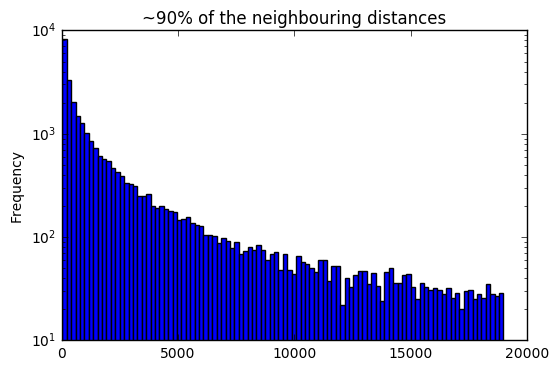

In [52]:
ax = ndser[ndser <= 18995].plot.hist(bins=100)
ax.set_title('~90% of the neighbouring distances')
ax.set_yscale('log')